# **Evolución del índice tarifario**


---


El valor de las tarifas de servicios públicos (electricidad y gas) es un tópico permanentemente en agenda, debido a su impacto en las cuentas públicas. En este sentido, el estudio de la evolución mensual del índice tarifario en valor real permite identificar puntos de quiebre en las políticas públicas, así como períodos de atraso tarifario y de recomposición del valor real de las tarifas.

El presente archivo contiene el código utilizado para obtener, procesar, analizar y actualizar los datos relevados en el Boletín de Precios y Tarifas Públicas, publicado por el Centro de Estudio de Finanzas Públicas y el Instituto de Investigaciones Económicas de la Facultad de Ciencias Económicas de la Universidad de La Plata. Este boletín se enmarca dentro del proyecto "Precios de empresas públicas y privatizadas reguladas. Teoría, medición para la Argentina y política económica", PICT 2016-0338 del FONCYT. Sus autores son Cont, W.; Navajas, F. H. y Porto, A., entre otros.

Como resultado del análisis de datos, se presenta una figura en forma de gráfico de líneas, que permite visualizar la evolución del índice tarifario para la electricidad y el gas.

## Preliminar

### Lectura de archivos `.pdf`

Para la ejecución del siguiente código, se debe instalar el *package* `tabula-py`, necesario para la lectura de tablas en formato `.pdf`.

In [1]:
!pip install tabula-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 59.3 MB/s eta 0:00:00


### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [2]:
import pandas as pd
import tabula
from urllib.request import Request, urlopen
import datetime as dt
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [3]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.4 MB/s eta 0:00:00


## Obtención de datos

Como fuera especificado anteriormente, el presente documento actualiza los datos publicados en el Boletín de Precios y Tarifas Públicas.

La última publicación del Boletín (#13, de febrero del año 2023) actualiza los datos hasta diciembre del año 2022.

Sin embargo, la publicación #13 discontinúa la Tabla 5: "Precios y tarifas por bienes en valores constantes. Enero 2015 a septiembre 2022. Índices diciembre 2015 = 100", de la cual se extraen los datos de los valores reales de las tarifas de servicios públicos.

En este sentido, se utilizarán 2 archivos:
*   la edición #12 del Boletín, publicada en octubre del año 2022 y actualizada hasta septiembre del mismo año: `url_boletin` refiere a este archivo.
*   la edición #13 del Boletín, publicada en febrero del año 2023 y actualizada hasta diciembre del año 2022: `url_boletin_2022` refiere a este archivo.

In [4]:
url_boletin = "https://www.mfp.econo.unlp.edu.ar/wp-content/uploads/2022/11/Boletin-no12-hasta-septiembre2022.pdf"

In [5]:
url_boletin_2022 = "https://www.econo.unlp.edu.ar/frontend/media/20/27120/6d0b1a2497b9a322285ef588927f67e4.pdf"

Así, utilizando la *library* `tabula`, es posible crear dos archivos de lectura:
*  `tarifas_historic`: se leen las páginas 18 a 20 del archivo referido en `url_boletin`.
*  `tarifas_2022`: se lee la página 20 del archivo referido en `url_boletin_2022`.

In [6]:
tarifas_historic = tabula.read_pdf(url_boletin, pages=[18, 19, 20], pandas_options={'header': None})

In [7]:
tarifas_2022 = tabula.read_pdf(url_boletin_2022, pages=[20], pandas_options={'header': None})

## *Data cleaning*

Tanto `tarifas_historic` como `tarifas_2022` son archivos en forma de lista, tal que sus *n* elementos interiores son *DataFrames*.

Para extraer eficientemente los datos deseados de dichos *DataFrames*, se comienza el proceso de *data cleaning* por `tarifas_historic`.

En este sentido, se definen -para cada una de las páginas leídas (18, 19 y 20) las columnas que refieren a la electricidad (`columns_elec`) y al gas (`columns_gas`).

In [8]:
columns_elec = [15, 11, 11]

In [9]:
columns_gas = [17, 12, 12]

Se crea un nuevo *DataFrame* vacío, `tarifas`, que servirá para adjuntar los datos finales.

In [10]:
tarifas = pd.DataFrame()

Iterando sobre los elementos interiores de `tarifas_historic`, y recordando que cada elemento interior es un *DataFrame* en particular, se extraen los valores del índice tarifario para la Electricidad y el Gas, se renombran las columnas y se adjuntan al *DataFrame* vacío (`tarifas`).

La información adjunta a `tarifas` comprende los valores hasta julio del año 2022, que corresponde con el último dato de la hoja 20 (última hoja leída).

In [11]:
for i, column_elec, column_gas in zip(range(3), columns_elec, columns_gas):
  series = tarifas_historic[i].loc[0:, [column_elec, column_gas]]
  series.columns = ["Electricidad", "Gas"]
  tarifas = tarifas.append(series, ignore_index=True)

Se eliminan las primeras dos filas del *DataFrame* `tarifas` y se resetea el índice.

In [12]:
tarifas = tarifas[2:].reset_index(drop=True)

Ahora bien, el archivo `tarifas_2022` contiene un solo elemento interior, por lo que no se precisa iterar sobre él. En particular, se seleccionan las filas y columnas deseadas mediante el comando `.loc[row_indexer,col_indexer]` y se resetea el índice.

In [13]:
tarifas_2022 = tarifas_2022[0].loc[20:,[9, 10]].reset_index(drop=True)

Por error de lectura, la columna "9" conjuga 2 valores separados por un espacio, se utiliza `.str.split()` para separarlos y utilizar solamente el segundo valor.

In [14]:
tarifas_2022[9] = tarifas_2022[9].str.split(' ', 2, expand=True)[1]

Se actualizan los nombres de las columnas de `tarifas_2022`.

In [15]:
tarifas_2022.columns = ["Electricidad", "Gas"]

La serie completa del índice tarifario (desde enero del año 2015 hasta el último dato publicado) surge de la concatenación vertical de los *DataFrames* `tarifas` y `tarifas_2022`.

In [16]:
tarifas = pd.concat([tarifas, tarifas_2022])

Los valores en `tarifas` son interpretados como cadenas de texto (`string`). Se actualiza su *type* mediante el comand `astype()`, siendo éste actualizado a `float`.

In [17]:
for column in tarifas.columns:
  tarifas[column] = tarifas[column].astype(float)

Finalmente, se resetea el índice.

In [18]:
tarifas = tarifas.reset_index(drop=True)

## Actualizaciones manuales

Dado que el Boletín de Precios y Tarifas Públicas no es publicado mensualmente, la actualización mensual entre publicaciones debe efectuarse de forma manual.

En este sentido, la presente sección actualiza el informe al mes de enero del año 2023.

### Valor nominal: electricidad

En este caso, el cálculo del valor nominal con impuestos para diciembre del año 2022 y para enero del año 2023 es igual.

In [19]:
elec_dic_2022 = elec_ene_2023 = ((227.61+218.51)/2+(9.205+9.19)/2*450)*1.27

### Valor nominal: gas

Se comienza calcular los Cargos Fijos (CF) para diciembre del año 2022 y enero del año 2023.

In [20]:
gas_CF_dic_2022 = gas_CF_ene_2023 = np.mean([326.771, 345.795, 395.818, 448.19, 586.17, 681.289, 914.501, 1485.218])

Luego, se calcula el Costo Variable para cada uno de los meses

In [21]:
gas_CV_dic_2022 = np.mean([23.791482, 24.96345, 24.099033, 24.450892, 25.026364])

In [22]:
gas_CV_ene_2023 = np.mean([31.599572, 31.904435, 31.907123, 32.258982, 32.834454])

El cálculo del valor nominal con impuestos se efectúa como una suma entre el Costo Fijo y 157 unidades del Costo Variable. Al resultado de la suma, se lo multiplica por 1.34, en concepto de impuestos.

In [23]:
gas_CF_CV_dic_2022 = (gas_CF_dic_2022 + gas_CV_dic_2022*157)*1.34

In [24]:
gas_CF_CV_ene_2023 = (gas_CF_ene_2023 + gas_CV_ene_2023*157)*1.34

### Valor real

Se comienza por explicitar los valores del nivel general del Índice de Precios al Consumidor (IPC) para la Región GBA para el mes de estudio (enero del año 2023) y el mes pasado (diciembre del año 2022).

In [25]:
ipc_dic_2022, ipc_ene_2023 = 1114.5359, 1180.967

Tanto para la electricidad como para el gas, el cálculo de los valores reales viene dado como un incremento nominal deflactado por los valores del IPC.

In [26]:
electricidad_enero_2023 = tarifas["Electricidad"][len(tarifas)-1]*(elec_ene_2023/elec_dic_2022)/(ipc_ene_2023/ipc_dic_2022)

In [27]:
gas_enero_2023 = tarifas["Gas"][len(tarifas)-1]*(gas_CF_CV_ene_2023/gas_CF_CV_dic_2022)/(ipc_ene_2023/ipc_dic_2022)

## *DataFrame* final

Los valores reales de las actualizaciones del índice tarifario son unidos al *DataFrame* final, `tarifas`.

In [28]:
tarifas.loc[len(tarifas)] = [electricidad_enero_2023, gas_enero_2023] 

Se crea un índice temporal en la columna "Período".

In [29]:
tarifas["Período"] = pd.date_range('01/01/2015', '01/01/2023', freq='MS')

Se reordenan las columnas.

In [30]:
tarifas = tarifas[["Período"]+tarifas.columns[0:2].tolist()]

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [31]:
tarifas.head()

,Período,Electricidad,Gas
0,2015-01-01,126.0,126.0
1,2015-02-01,124.0,124.0
2,2015-03-01,121.0,121.0
3,2015-04-01,119.0,119.0
4,2015-05-01,117.0,117.0


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [32]:
tarifas.to_excel("Evolución del índice tarifario.xlsx", index=False)

## Figura: Evolución del índice tarifario

Al tratarse de una sola figura, en este caso, no es necesario definir una función, sino que las especificaciones de la figura se encuentran en el argumento de ésta.

Sin embargo, resulta eficiente crear una función para modificar el aspecto de la figura en general. Así, la función `tarifas_update_layout` contiene el código necesario para esta visualización.

Sus parámetros son:
*   `fig`: el nombre de la figura a utilizar.
*   `df`: el *DataFrame* que contiene la información a graficar.
*   `min`: valor mínimo del eje de ordenadas.
*   `max`: valor máximo del eje de ordenadas.
*   `title_text`: título del eje de ordenadas.

In [33]:
def tarifas_update_layout(fig, df, min, max, title_text):
  fig.update_layout(
    plot_bgcolor = 'rgba(0,0,0,0)',
    margin = dict(
        b=15,
        t=15,
        l=15,
        r=50
    ),
    legend = dict(
        title = None,
        orientation = 'h',
        xanchor = 'center', 
        x = 0.5, 
        yanchor = 'bottom', 
        y = 1,
        font = dict(
            size = 16
        )),
    height = 750,
    width = 1000,
    xaxis = dict(
        range = [df["Período"][0], dt.date(df["Período"][len(df)-1].year, df["Período"][len(df)-1].month, 28)],
        title = None,
        tickformat = "%m\n<b>%Y",
        dtick = "M3",
        tickangle = 0
        ),
    yaxis = dict(
        range = [min, max],
        dtick=100,
        title = dict(
            text=title_text
            ),
        showgrid=True,
        gridcolor='lightgray'
        ),
    font = dict(
        size = 14,
        family = "serif"
        )
    )

Se establece un color para cada servicio público.

In [34]:
colors_servicio = ['rgb(127,60,141)', 'rgb(17,165,121)']

Se crea la figura `tarifas_fig` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [35]:
tarifas_fig = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `tarifas_update_layout` para modificar el aspecto de la figura en general.

In [36]:
for servicio, color in zip(tarifas.columns[1:], colors_servicio):
  tarifas_fig.add_trace(
        go.Scatter(
            x=tarifas["Período"],
            y=tarifas[servicio],
            mode='lines',
            line=dict(color=color, width=2),
            name=servicio
        ))
  tarifas_fig.add_trace(
        go.Scatter(
            showlegend=False,
            x=tarifas["Período"].tail(1),
            y=tarifas[servicio].tail(1),
            mode='markers',
            marker=dict(color=color, size=10),
            name=servicio+" - EoP"
        )
    )
  tarifas_fig.add_annotation(
        x=pd.to_datetime(tarifas["Período"][-1:].values[0]),
        y=tarifas[servicio][-1:].values[0],
        text=round(tarifas[servicio][-1:].values[0], 1).astype(str),
        font=dict(color=color),
        xanchor="left",
        xshift=10,
        yshift=0,
        showarrow=False
    )
  
tarifas_fig.add_trace(go.Scatter(
    x=[tarifas['Período'][25], tarifas['Período'][25]],
    y=[0, 1350],
    mode='lines+text',
    line=dict(color='lightgray', width=2, dash='dash'),
    text="cambio de tarificación - electricidad",
    textposition='top center',
    textfont=dict(color='gray'),
    showlegend=False
))

tarifas_update_layout(tarifas_fig, tarifas, 50, 1410, "<b>Índice (base dic. 2015 = 100)")

A continuación, se exhibe la figura.

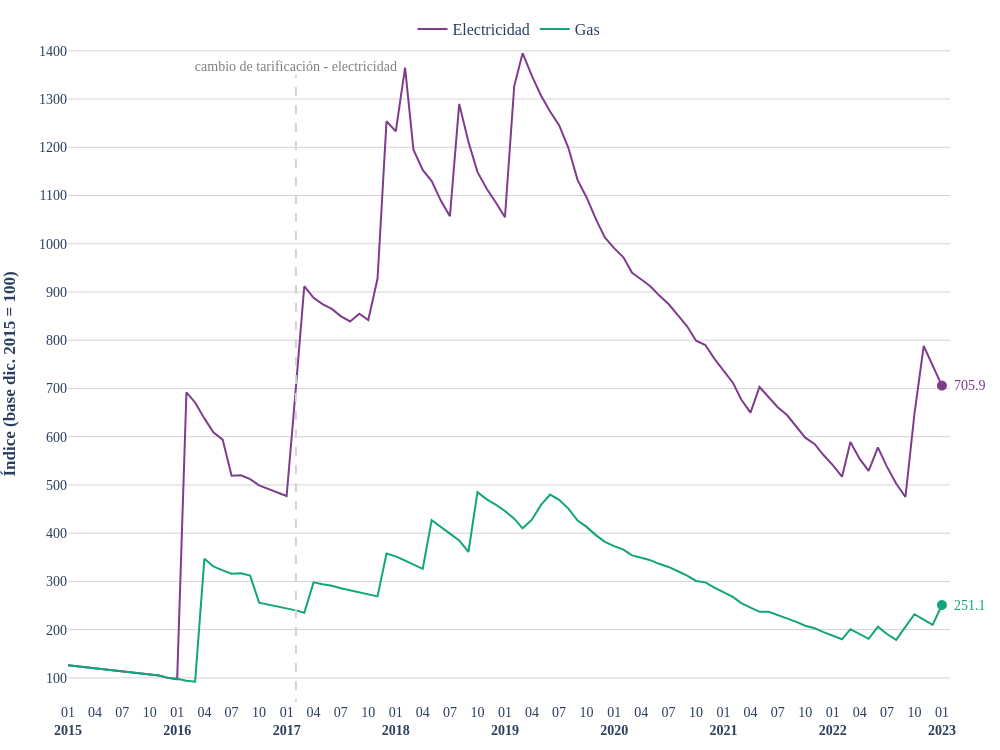

In [37]:
tarifas_fig.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [38]:
pio.write_image(tarifas_fig, "Figura Tarifas.pdf", width=3*300, height=2.25*300)